In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import tensorflow as tf

In [10]:
# Veri setini yükleme ve işleme adımları
data = pd.read_csv(r"Data1/data.csv")

# Resim boyutları
height, width = 224, 224

# Resimleri yükleme ve işleme
X = np.empty((data.shape[0], height, width, 3))
for i in range(data.shape[0]):
    img = load_img(r"Data1/{}/{}.jpg".format(data.loc[i, 'label'], data.loc[i, 'images_id']),
                   target_size=(height, width))
    # Piksel değerlerini [0, 1] aralığına normalleştirme
    img_array = img_to_array(img)
    img_array /= 255.0
    X[i] = img_array

# Etiketleri değiştirme
labels = data.label.unique()
labels = {labels[i]: i for i in range(labels.size)}
y = data.label.map(labels)

# One-hot encoding
y = to_categorical(y, len(labels))

# Veri setini train-test olarak ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [11]:
# InceptionV3 modelini yükleme
inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(height, width, 3))

# Transfer learning: InceptionV3 modelinin üstüne yeni katmanlar ekleyerek özelleştirme
x = Flatten()(inceptionv3.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.45)(x)
output = Dense(len(labels), activation='softmax')(x)

# Yeni modeli oluşturma
model_inceptionv3 = Model(inceptionv3.input, output)

# Modeli derleme
model_inceptionv3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [12]:
epochs = 15
# Modelin eğitimi
stats_inceptionv3 = model_inceptionv3.fit(X_train, y_train, epochs=epochs, validation_split=0.2)


Epoch 1/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.5946 - loss: 7.9976 - val_accuracy: 0.4589 - val_loss: 6599.7109
Epoch 2/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.9283 - loss: 0.4556 - val_accuracy: 0.4589 - val_loss: 4405.9272
Epoch 3/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 132s 5s/step - accuracy: 0.9795 - loss: 0.0444 - val_accuracy: 0.4589 - val_loss: 67.2260
Epoch 4/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.9954 - loss: 0.0140 - val_accuracy: 0.4589 - val_loss: 14.7889
Epoch 5/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9975 - loss: 0.0179 - val_accuracy: 0.4589 - val_loss: 6303.6499
Epoch 6/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9804 - loss: 0.1083 - val_accuracy: 0.8261 - val_loss: 0.7135
Epoch 7/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.9785 - loss: 0.0764 - val_accuracy: 0.8647 - val_loss: 0.5560
Epoch 8/15
26/26 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.9973 - loss: 0.0106 - val_accuracy: 0.980

Accuracy:
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 261ms/step - accuracy: 0.9939 - loss: 0.0455
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step


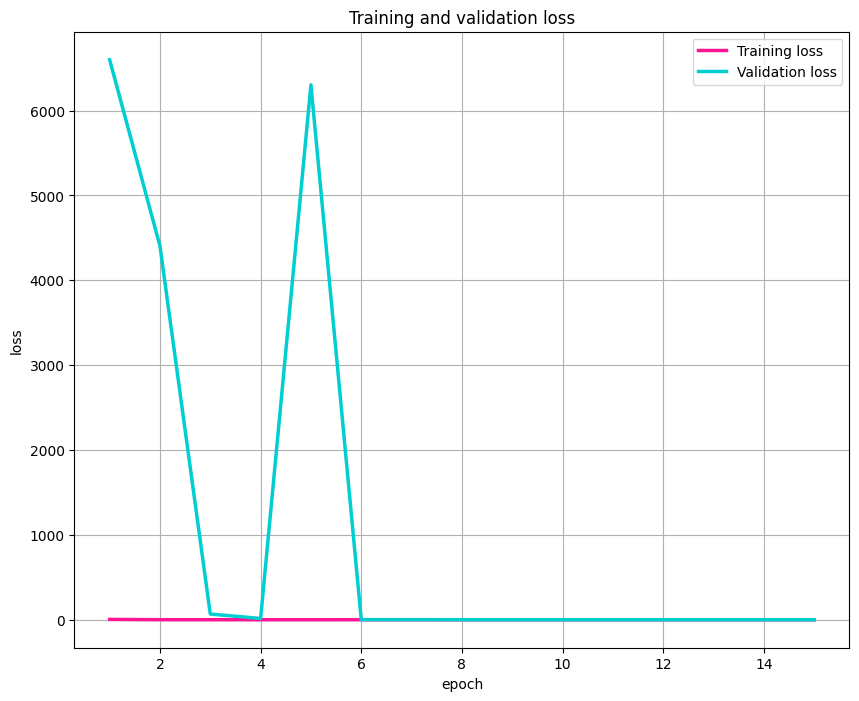

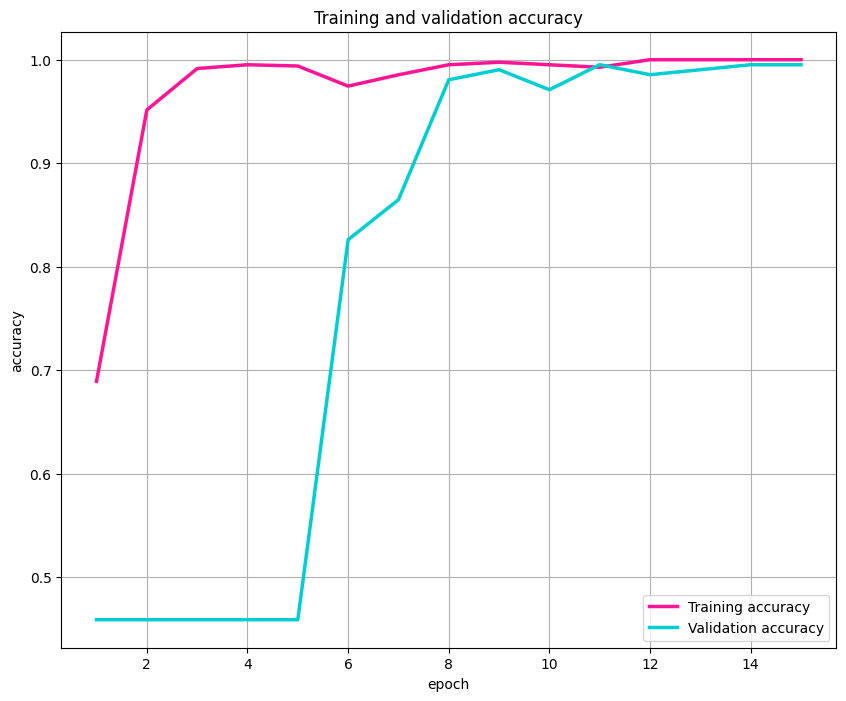

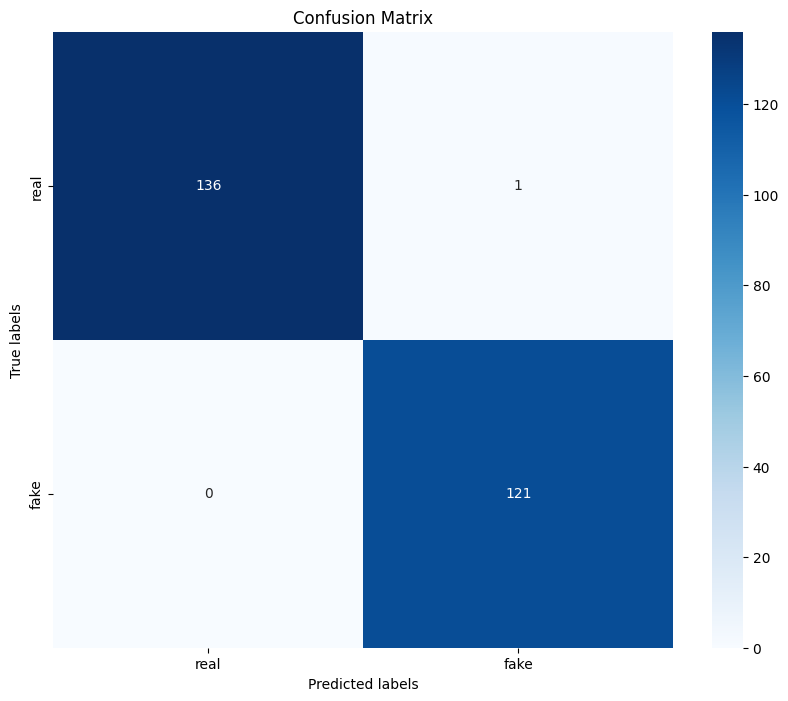

In [14]:
# Eğitim istatistiklerini görselleştirme
stats_inceptionv3_df = pd.DataFrame(stats_inceptionv3.history)
stats_inceptionv3_df['epoch'] = list(range(1, epochs+1))

plt.figure(figsize=(10, 8))
sns.lineplot(y='loss', x='epoch', data=stats_inceptionv3_df, color='deeppink', linewidth=2.5, label="Training loss")
sns.lineplot(y='val_loss', x='epoch', data=stats_inceptionv3_df, color='darkturquoise', linewidth=2.5, label="Validation loss")
plt.grid()
plt.legend()
plt.title("Training and validation loss")

plt.figure(figsize=(10, 8))
sns.lineplot(y='accuracy', x='epoch', data=stats_inceptionv3_df, color='deeppink', linewidth=2.5, label="Training accuracy")
sns.lineplot(y='val_accuracy', x='epoch', data=stats_inceptionv3_df, color='darkturquoise', linewidth=2.5, label="Validation accuracy")
plt.grid()
plt.legend()
plt.title("Training and validation accuracy")

# Test verisi üzerinde modelin performansını değerlendirme
print('Accuracy:')
_, accuracy_inceptionv3 = model_inceptionv3.evaluate(X_test, y_test)

# Confusion Matrix
# Tahminler
y_pred_inceptionv3 = model_inceptionv3.predict(X_test)
y_pred_classes_inceptionv3 = np.argmax(y_pred_inceptionv3, axis=1)

# Confusion matrix
# Test veri kümesinden doğru etiketleri y_true olarak tanımla
y_true = np.argmax(y_test, axis=1)

confusion_mtx_inceptionv3 = confusion_matrix(y_true, y_pred_classes_inceptionv3)

# Görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx_inceptionv3, annot=True, fmt='g', cmap='Blues', xticklabels=labels.keys(), yticklabels=labels.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()